In [1]:
from utility_dfplotter import *

# 1. Plot Z+Fake distributions 

In [4]:
def getDFList(faketype):
    if faketype == 'e':
        tag = '*'
    if faketype == 'mu':
        tag = 'ee'
    if faketype == 'tau':
        tag = 'emu'
    # Diboson
    pickles  = glob.glob("../data/pickles/{}_{}/mcdiboson/*.pkl".format(tag,faketype))
    MCzz = pd.concat([ pd.read_pickle(pickle) for pickle in pickles ], ignore_index=True)
    # DY
    pickles  = glob.glob("../data/pickles/{}_{}/mcdy/*.pkl".format(tag,faketype))
    MCdy = pd.concat([ pd.read_pickle(pickle) for pickle in pickles], ignore_index=True)
    # tW
    pickles  = glob.glob("../data/pickles/{}_{}/mct/*.pkl".format(tag,faketype))
    MCt = pd.concat([ pd.read_pickle(pickle) for pickle in pickles], ignore_index=True)
    # tt
    pickles  = glob.glob("../data/pickles/{}_{}/mctt/ntuple_ttbar_inclusive.pkl".format(tag,faketype))
    MCtt = pd.concat([ pd.read_pickle(pickle) for pickle in pickles], ignore_index=True)

    # data
    pickles  = glob.glob("../data/pickles/{}_{}/data2016/*.pkl".format(tag,faketype))
    Data = pd.concat([ pd.read_pickle(pickle) for pickle in pickles], ignore_index=True)

    
    
    
     
    if faketype == 'e':
        dfList = [MCt,MCtt,MCdy,MCzz,Data]
        for df in dfList: 
            df['passElISO'] = MCtt.lepton3_isopass==1.0          
            df.lepton3_iso = df.lepton3_iso/df.lepton3_pt            
            df.query('lepton3_pt>10',inplace=True)
            
            
    if faketype == 'mu':
        dfList = [MCt,MCtt,MCdy,MCzz,Data]
        for df in dfList: 
            df.lepton3_iso = df.lepton3_iso/df.lepton3_pt
            df.query('lepton3_pt>10',inplace=True)
            
    if faketype == 'tau':
        dfList = [MCzz,MCdy,MCt,MCtt,Data]
        for df in dfList: 
            df.query('lepton3_pt>20',inplace=True)

        df.query('lepton3_pt>10',inplace=True)
        df.reset_index(drop=True,inplace=True)
            
    return dfList

def plotDFList(faketype):
    dfList = getDFList(faketype)
    
#     if faketype == 'tau':
#         pp = pd.read_csv("../scripts/plotterItemTables/itemTable_fake{}.csv".format(faketype))
#     else:
#         pp = pd.read_csv("../scripts/plotterItemTables/itemTable_zl.csv")
        
    pp = pd.read_csv("../scripts/plotterItemTables/itemTable_fake{}.csv".format(faketype))
    for index, row in pp.iterrows():
        v,a,b,step,xl = row["var"],row["lower"],row["upper"],row["step"],row["xlabel"]
        sk = ASingleKinematicPlot(v,a,b,step,dfList)
        sk.settingPlot(xl, ['tW','tt','V+Jets','Diboson','Data'], ['C3','C2','C1','C0','k'],logscale=False)
        if faketype == 'tau':
            sk.settingPlot(xl, ['Diboson','V+Jets','tW','tt','Data'], ['C3','C2','C1','C0','k'],logscale=True)
        sk.makePlot('../plots/kinematics/z{}/'.format(faketype))
        
        print("making plots : {}/{}".format(index+1, len(pp)) )
        clear_output(wait=True)
        plt.close()

In [5]:
plotDFList('tau')

making plots : 22/22


# 2. Measure Fake Rate

In [23]:
ptbins  = [10,12,14,16,20,25,30,50]

def ratioVar(up,down,upVar,downVar):
    ratio = up/down
    ratioVar = ratio**2
    ratioVar *= (upVar/up**2 + downVar/down**2)
    return ratioVar
    
def getFakeRate(faketype):
    normprompt = 1.
    
    ls = getDFList(faketype)
    fake,prompt,data = pd.concat(ls[0:3], ignore_index=True),ls[3],ls[4]
    if faketype=='mu':
        passIso = 'lepton3_iso<0.15'
        failIso = 'lepton3_iso>0.15'
    elif faketype=='e':
        passIso = 'passElISO==True'
        failIso = 'passElISO==False'

    
    records = []

    for i in range(len(ptbins)-1):
        a,b = ptbins[i],ptbins[i+1]
        inPtBin = '& lepton3_pt>{} & lepton3_pt<{}'.format(a,b)

        ndataPass = sum(data.query(passIso+inPtBin).eventWeight)
        ndataFail = sum(data.query(failIso+inPtBin).eventWeight)
        npromptPass = sum(prompt.query(passIso+inPtBin).eventWeight)*normprompt 
        npromptFail = sum(prompt.query(failIso+inPtBin).eventWeight)*normprompt 
        nfakePass = sum(fake.query(passIso+inPtBin).eventWeight)
        nfakeFail = sum(fake.query(failIso+inPtBin).eventWeight)

        ndataPassVar = sum(data.query(passIso+inPtBin).eventWeight**2)
        ndataFailVar = sum(data.query(failIso+inPtBin).eventWeight**2)
        npromptPassVar = sum(prompt.query(passIso+inPtBin).eventWeight**2)
        npromptFailVar = sum(prompt.query(
            
            
            
            
        failIso+inPtBin).eventWeight**2)
        nfakePassVar = sum(fake.query(passIso+inPtBin).eventWeight**2)
        nfakeFailVar = sum(fake.query(failIso+inPtBin).eventWeight**2)

        records.append([a,b,
                        ndataPass, ndataFail, ndataPassVar, ndataFailVar,
                        npromptPass, npromptFail,npromptPassVar, npromptFailVar,
                        nfakePass, nfakeFail,nfakePassVar, nfakeFailVar
                       ])

    df = pd.DataFrame.from_records(records, columns=['a','b',
                                                     'ndataPass', 'ndataFail', 'ndataPassVar', 'ndataFailVar',
                                                     'npromptPass', 'npromptFail', 'npromptPassVar', 'npromptFailVar',
                                                     'nfakePass', 'nfakeFail', 'nfakePassVar', 'nfakeFailVar'])

    df['width'] = df.b - df.a
    df['c'] = (df.b + df.a)/2
    df['fakeRateData'] = (df.ndataPass - df.npromptPass)/(df.ndataFail - df.npromptFail)
    df['fakeRateMC'] = df.nfakePass / df.nfakeFail

    df['fakeRateDataSigma'] = ratioVar(df.ndataPass-df.npromptPass,
                                       df.ndataFail-df.npromptFail,
                                       df.ndataPassVar+df.npromptPassVar,
                                       df.ndataFailVar+df.npromptFailVar)**0.5

    df['fakeRateMCSigma'] = ratioVar(df.nfakePass,df.nfakeFail,df.nfakePassVar,df.nfakeFailVar)**0.5
    
    for i in range(len(df)):
        print('{:5.3f}+/-{:5.3f},{:5.3f}+/-{:5.3f}'.format(df.fakeRateData[i],df.fakeRateDataSigma[i],df.fakeRateMC[i],df.fakeRateMCSigma[i]))
    return df

def plotFakeRate(df,faketype):
    plt.rc("figure",facecolor="w")
    fig, axes = plt.subplots(2, 1, sharex=True, 
                             gridspec_kw={'height_ratios':[3,1]},
                             figsize=(6,6))
    fig.subplots_adjust(hspace=0)

    ax = axes[0]

    ax.hist([df.c,df.c],ptbins,
            weights=[df.npromptFail/df.width, df.nfakeFail/df.width],
            label=['prompt (failISO)','nonprompt (failISO)'],
            histtype='stepfilled',color=['C0','C1'],stacked=True,alpha=0.5)

    ax.hist([df.c,df.c],ptbins,
            weights=[df.npromptPass/df.width, df.nfakePass/df.width],
            label=['prompt (passISO)','nonprompt (passISO)'],
            histtype='step',color=['C0','C1'],lw=3,stacked=True)#'skyblue','navajowhite'


    ax.errorbar(df.c,df.ndataFail/df.width, 
                yerr = df.ndataFailVar**0.5,
                fmt='o', markersize=5,color = "darkblue",label='data (failISO)')

    ax.errorbar(df.c, df.ndataPass/df.width,
                yerr = df.ndataPassVar**0.5,
                fmt='s',markersize=5, color="k", label='data (passISO)')

    ax.legend()
    ax.set_yscale('log')
    ax.grid(color='grey',linestyle='--',alpha=0.4)
    if faketype == 'e':
        ax.set_ylim(0.01,10*np.max(df.ndataFail/df.width))
    if faketype == 'mu':
        ax.set_ylim(1,10*np.max(df.ndataFail/df.width))
    ax.text(df.c[0], 4*np.max(df.ndataFail/df.width), 
        r'CMS $preliminary$',
        style="italic",fontsize="15",fontweight='bold')
    #ax.set_xlim(0.,100)
    ax.set_title("L=35.9/fb (13TeV)",loc="right")
    ax = axes[1]
    
    ax.fill_between(df.c,df.fakeRateData+df.fakeRateDataSigma,df.fakeRateData-df.fakeRateDataSigma,color='C0', linewidth=0, alpha=0.6,label='FR: data-prompt')
    ax.fill_between(df.c,df.fakeRateMC+df.fakeRateMCSigma,df.fakeRateMC-df.fakeRateMCSigma,color='C1', linewidth=0, alpha=0.6,label='FR: nonprompt')
    #ax.axhline(0.05,c="k")
    if faketype == 'e':
        ax.legend(loc='lower right')
        ax.set_ylim(0.0,0.20)
    if faketype == 'mu':
        ax.legend(loc='upper right')    
        ax.set_ylim(0.0,0.20)
    
    ax.plot(df.c,df.fakeRateData,color='C0', linestyle='--',alpha=1,lw=2)
    ax.plot(df.c,df.fakeRateMC,color='C1', linestyle='--', alpha=1)
    
    
    #ax.set_xlim(0.,100)
    ax.grid(color='grey',linestyle='--',alpha=0.4)
    ax.set_xlabel('Fakes_pT [GeV]')

    #plt.savefig('../plots/kinematicsWithFakes/e4j/fakerate.png',dpi=300)

0.138+/-0.017,0.099+/-0.014
0.130+/-0.019,0.169+/-0.028
0.137+/-0.023,0.124+/-0.023
0.129+/-0.017,0.166+/-0.022
0.159+/-0.023,0.097+/-0.013
0.126+/-0.024,0.099+/-0.016
0.136+/-0.017,0.138+/-0.015


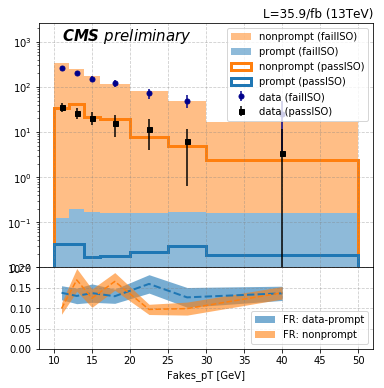

In [24]:
df = getFakeRate('e')
plotFakeRate(df,'e')
plt.savefig('../plots/kinematicsWithFakes/e4j/fakerate.pdf')

0.089+/-0.005,0.092+/-0.006
0.070+/-0.006,0.074+/-0.006
0.072+/-0.007,0.061+/-0.006
0.060+/-0.006,0.047+/-0.004
0.046+/-0.008,0.050+/-0.006
0.061+/-0.014,0.042+/-0.007
0.078+/-0.015,0.052+/-0.007


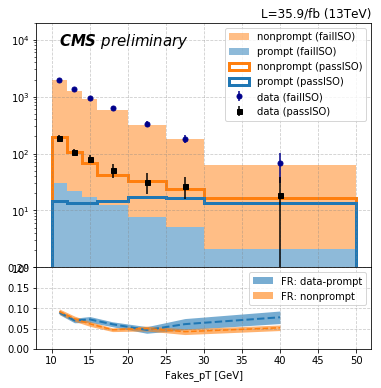

In [25]:
df = getFakeRate('mu')
plotFakeRate(df,'mu')
plt.savefig('../plots/kinematicsWithFakes/mu4j/fakerate.pdf')

In [70]:
def getFakeRateSS(tr):
    v,a,b,step,xl = "lepton2_pt",0,200,5,"lepton2_pt"
    
    plotter = DFPlotter(tr+'tau','==0')
    
    sk = ASingleKinematicPlot(v,a,b,step,plotter.getDataFrameList('ss'))
    sk.settingPlot(xl,plotter.labelList ,plotter.colorList )
    sk.makePlot()
    
    fakeProfileSS = sk.hdata-sk.mctot
    sk.axes[0].bar(sk.center,fakeProfileSS,sk.step,bottom=sk.mctot,color="gray",label="Fakes" )
    sk.axes[0].legend()
    plt.savefig('../plots/kinematicsWithFakes/{}tau/0bSS.png'.format(tr),dpi=300)
    plt.close()
    
    
    
    sk = ASingleKinematicPlot(v,a,b,step,plotter.getDataFrameList())
    sk.settingPlot(xl,plotter.labelList ,plotter.colorList )
    sk.makePlot()
    fakeProfileOS = sk.hdata-sk.mctot
    sk.axes[0].bar(sk.center,fakeProfileOS,sk.step,bottom=sk.mctot,color="gray",label="Fakes" )
    sk.axes[0].legend()
    plt.savefig('../plots/kinematicsWithFakes/{}tau/0bOS.png'.format(tr),dpi=300)
    plt.close()
    fakeProfileOS = sk.hdata-sk.mctot
    
    print( '{}tau fake normalization is {}'.format(tr,sum(fakeProfileOS)/sum(fakeProfileSS)) )
    

In [10]:
getFakeRateSS('e')
getFakeRateSS('mu')

etau fake normalization is 1.1149214686209652
mutau fake normalization is 1.265694158849715


# 3. Make Demo Plots

###  3.1 e and mu with inverse ISO

In [18]:
def plotPtWithISOFakes(tr):
    fr = common.getFakeSF(tr)
    print('fake normalization for {} is {}'.format(tr,fr))

    
    v,a,b,step,xl = "lepton1_pt",0,200,5,"lepton1_pt"

    # make fake plot
    plotter = DFPlotter(tr+'4j_fakes','==1')
    sk = ASingleKinematicPlot(v,a,b,step,plotter.getDataFrameList())
    sk.settingPlot(xl,plotter.labelList ,plotter.colorList )
    sk.makePlot()

    fakeProfile = sk.hdata - sk.mctot
    fakeProfile
    sk.axes[0].bar(sk.center,fakeProfile,sk.step,bottom=sk.mctot,color="gray",label="Fakes" )
    sk.axes[0].legend()
    plt.savefig('../plots/kinematicsWithFakes/{}4j/fakes1b_{}.png'.format(tr,v),dpi=300)
    #plt.savefig('../plots/kinematicsWithFakes/{}4j/fakes.pdf'.format(tr))
    plt.close()

    # make nominal plot
    plotter = DFPlotter(tr+'4j','==1')
    sk = ASingleKinematicPlot(v,a,b,step,plotter.getDataFrameList())
    sk.settingPlot(xl,plotter.labelList ,plotter.colorList )
    sk.makePlot()

    fakeProfile = fakeProfile*fr
    sk.axes[0].bar(sk.center,fakeProfile,sk.step,bottom=sk.mctot,color="gray",label="Fakes" )
    sk.axes[0].legend()

    sk.axes[1].plot(sk.center,sk.hdata/(fakeProfile+sk.mctot),'r.')
    plt.savefig('../plots/kinematicsWithFakes/{}4j/nominal1b_{}.png'.format(tr,v),dpi=300)
    #plt.savefig('../plots/kinematicsWithFakes/{}4j/nominal.pdf'.format(tr))
    #plt.close()
    
def plotPtWithSSFakes(tr):
    
    v,a,b,step,xl = "lepton1_pt",0,200,5,"lepton1_pt"
    
    # make fake plot
    plotter = DFPlotter(tr+'tau','==1')
    sk = ASingleKinematicPlot(v,a,b,step,plotter.getDataFrameList('ss'))
    sk.settingPlot(xl, plotter.labelList, plotter.colorList)
    sk.makePlot()
    
    fakeProfile = sk.hdata-sk.mctot
    sk.axes[0].bar(sk.center,fakeProfile,sk.step,bottom=sk.mctot,color="grey",label="Fakes" )
    sk.axes[0].legend()
    plt.savefig('../plots/kinematicsWithFakes/{}tau/fakes1b_{}.png'.format(tr,v),dpi =300)
    #plt.savefig('../plots/kinematicsWithFakes/{}tau/fakes1b_{}.pdf'.format(tr,v))
    plt.close()
    
    # make nominal plot
    sk = ASingleKinematicPlot(v,a,b,step,plotter.getDataFrameList(),adjust=[1,1,1,1,1,1,.89/.95])
    sk.settingPlot(xl, plotter.labelList, plotter.colorList)
    sk.makePlot()
    
    fakeProfile = fakeProfile*1.0
    sk.axes[0].bar(sk.center,fakeProfile,sk.step,bottom=sk.mctot,color="grey",label="Fakes" )
    sk.axes[0].legend()
    
    sk.axes[1].plot(sk.center, sk.hdata/(fakeProfile+sk.mctot), 'r.')
    plt.savefig('../plots/kinematicsWithFakes/{}tau/nominal1b_{}.png'.format(tr,v),dpi =300)
    #plt.savefig('../plots/kinematicsWithFakes/{}tau/nominal1b_{}.pdf'.format(tr,v))
    #plt.close()

fake normalization for e is 0.12


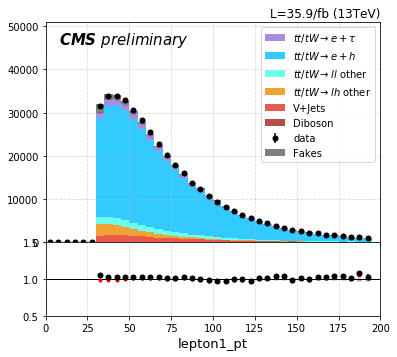

In [19]:
plotPtWithISOFakes('e')
#plotPtWithSSFakes('e')

fake normalization for mu is 0.09


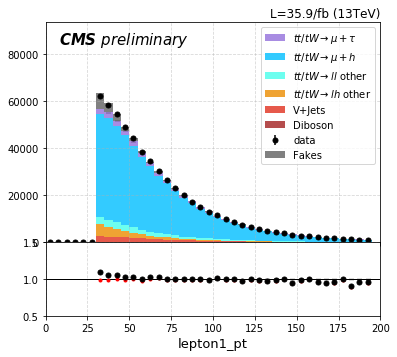

In [20]:
plotPtWithISOFakes('mu')
#plotPtWithSSFakes('mu')